# Retrieve and plot MODIS images for ASC

- Using earthaccess package, see https://github.com/nsidc/earthaccess
- Need earthdata account, see https://urs.earthdata.nasa.gov/

In [76]:
import earthaccess
import os
import warnings
import matplotlib.pyplot as plt
import numpy.ma as ma
import xarray as xr
import rioxarray as rxr
from shapely.geometry import mapping, box
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import pyproj

import rasterio as rio
from rasterio.crs import CRS
from rasterio import plot
from rasterio.transform import Affine
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.axes import Axes
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import numpy as np
import pyproj
import glob
import pandas as pd
import datetime

import satpy
from satpy.scene import Scene
from satpy import find_files_and_readers
import pyresample as prs

### Open SR flight data

In [93]:
def matlab_time_to_numpydt64(datevar,timevar):
    new_time_list = []
    for i in range(len(datevar)):
        date = pd.to_datetime(datevar[i].data, format='%Y%m%d')
        secs = datetime.timedelta(seconds=int(timevar[i].data))
        datetime64 = np.datetime64(date + secs)
        new_time_list.append(datetime64.astype('datetime64[ns]'))
    new_time_arr = np.array(new_time_list)
    return new_time_arr

def ws_from_uv(u,v):
    ws = (u**2 + v**2)**0.5
    return ws

# fetch flight adjusted for sr files only
def fetch_flight(ds_list,fli_no):
    for ds in ds_list:
            if ds.flightno[0].values in [fli_no]:
                ds_out = ds
    return ds_out

### open ASC QC short run files
indir = '/local/jbj13rpu/Documents/Arctic_Summertime_Cyclones/code/ASC_QC_V2/databases/'
f_list_all = []
ds_list_sr = []

for f in glob.iglob(indir + '*sr*' + '.txt', recursive=True):
    f_list_all.append(f)
    d,fn = os.path.split(f)
    fli_no = float(fn[-7:-4])
    
    df = pd.read_csv(f,sep='\s',engine='python')
    ds = df.to_xarray()
    ds['meantime64'] = xr.DataArray(matlab_time_to_numpydt64(ds['yyyymmdd'],ds['meantime']),
                                    coords={'index':ds.index})
    ds['starttime64'] = xr.DataArray(matlab_time_to_numpydt64(ds['yyyymmdd'],ds['starttime']),
                                    coords={'index':ds.index})
    ds['endtime64'] = xr.DataArray(matlab_time_to_numpydt64(ds['yyyymmdd'],ds['endtime']),
                                    coords={'index':ds.index})
    
    
    WS10m = ws_from_uv(ds['u'],ds['v'])
    ds['WS10m'] = xr.DataArray(WS10m,coords={'index':ds.index})
    
    ### trial adjusted sea ice fraction calculation 
    ### following Elvidge et al. 2016
    ### using estimated values from Flight 380 video and data analysis
    # A0 = median lead value
    alb_A0 = 0.2
    # A1 = min sea ice with melt pond only value
    # note, higher values for broken sea ice exist... Problem!
    alb_A1 = 0.6
    ds['sea_ice_fraction_alb_adj'] = ds.icefractionalb.copy()
    ds['sea_ice_fraction_alb_adj'] = xr.DataArray(np.zeros(len(ds['sea_ice_fraction_alb_adj'])),
                                           coords={'index':ds.index})
    for i,albedo in enumerate(ds.alb.data):
        if albedo <= alb_A0:
            ds['sea_ice_fraction_alb_adj'][i] = 0
        if albedo > alb_A0 and albedo < alb_A1:
            sif = (albedo - alb_A0) / (alb_A1 - alb_A0)
            ds['sea_ice_fraction_alb_adj'][i] = sif
        if albedo >= alb_A1:
            ds['sea_ice_fraction_alb_adj'][i] = 1
    
    ds_list_sr.append(ds)

### Find and retrieve MODIS granules

In [35]:
# search for granules by time and space parameters
auth = earthaccess.login()
results = earthaccess.search_data(
    short_name='MOD09GA',
    cloud_hosted=True,
    bounding_box=(-20, 81.5, -18, 83),
    temporal=("2022-08-15", "2022-08-16"),
    count=10
)
results

We are already authenticated with NASA EDL
Granules found: 2


[Collection: {'ShortName': 'MOD09GA', 'Version': '061'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -3.00988215717355, 'Latitude': 78.9233539406271}, {'Longitude': 91.446762896477, 'Latitude': 84.4840414516341}, {'Longitude': -145.40339524867, 'Latitude': 83.7811776372583}, {'Longitude': -58.207908386468, 'Latitude': 78.5531939231829}, {'Longitude': -3.00988215717355, 'Latitude': 78.9233539406271}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2022-08-15T00:00:00.000Z', 'EndingDateTime': '2022-08-15T23:59:59.000Z'}}
 Size(MB): 728.182
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD09GA.061/MOD09GA.A2022227.h17v00.061.2022229034933/MOD09GA.A2022227.h17v00.061.2022229034933.hdf'],
 Collection: {'ShortName': 'MOD09GA', 'Version': '061'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -3.00988215717355, 'Lati

In [86]:
data_links = [granule.data_links(access="direct") for granule in results]
data_links

[['s3://lp-prod-protected/MOD09GA.061/MOD09GA.A2022227.h17v00.061.2022229034933/MOD09GA.A2022227.h17v00.061.2022229034933.hdf'],
 ['s3://lp-prod-protected/MOD09GA.061/MOD09GA.A2022228.h17v00.061.2022232031925/MOD09GA.A2022228.h17v00.061.2022232031925.hdf']]

In [87]:
# download data
data_dir = './MODIS_data/'
os.makedirs(data_dir,exist_ok=True)

files = earthaccess.download(results[0:1], data_dir)

 Getting 1 granules, approx download size: 0.71 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File MOD09GA.A2022227.h17v00.061.2022229034933.hdf already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
# it's possible to stream data 
# (but xarray needs extra hdf backend to be able to open file)

# files = earthaccess.open(results[0:1])
# ds = xr.open_mfdataset(files)

### Test open image data

In [81]:
files
f = files[0]

In [84]:
data_dir = './MODIS_data/'

# Open image file gives two datasets:
# 0 = metadata
# 1 = image data

img_data = rxr.open_rasterio(data_dir+f)
meta = img_data[0]
meta

<xarray.Dataset>
Dimensions:               (band: 1, x: 1200, y: 1200)
Coordinates:
  * band                  (band) int64 1
  * x                     (x) float64 -1.111e+06 -1.111e+06 ... -1.39e+03 -463.3
  * y                     (y) float64 1.001e+07 1.001e+07 ... 8.896e+06
    spatial_ref           int64 0
Data variables:
    num_observations_1km  (band, y, x) int8 ...
    granule_pnt_1         (band, y, x) uint8 ...
    state_1km_1           (band, y, x) uint16 ...
    SensorZenith_1        (band, y, x) int16 ...
    SensorAzimuth_1       (band, y, x) int16 ...
    Range_1               (band, y, x) uint16 ...
    SolarZenith_1         (band, y, x) int16 ...
    SolarAzimuth_1        (band, y, x) int16 ...
    gflags_1              (band, y, x) uint8 ...
    orbit_pnt_1           (band, y, x) int8 ...
Attributes: (12/184)
    ADDITIONALLAYERS1KM:                 61
    ADDITIONALLAYERS500M:                13
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   30407383
    total_additional_observations_500m:  42085612
    VERSIONID:                           61
    VERTICALTILENUMBER:                  0
    WESTBOUNDINGCOORDINATE:              -179.999999543434
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

In [85]:
# Or just open some bands that you want to process
desired_bands = ["sur_refl_b01_1",
                 "sur_refl_b02_1",
                 "sur_refl_b03_1",
                 "sur_refl_b04_1",
                 "sur_refl_b07_1"]
# Notice that here, you get a single xarray object with just the bands that
# you want to work with, no metadata
img_data = rxr.open_rasterio(data_dir+f,
                            masked=True,
                            variable=desired_bands).squeeze()
img_data

<xarray.Dataset>
Dimensions:         (x: 2400, y: 2400)
Coordinates:
    band            int64 1
  * x               (x) float64 -1.112e+06 -1.111e+06 ... -695.0 -231.7
  * y               (y) float64 1.001e+07 1.001e+07 ... 8.896e+06 8.896e+06
    spatial_ref     int64 0
Data variables:
    sur_refl_b01_1  (y, x) float32 ...
    sur_refl_b02_1  (y, x) float32 ...
    sur_refl_b03_1  (y, x) float32 ...
    sur_refl_b04_1  (y, x) float32 ...
    sur_refl_b07_1  (y, x) float32 ...
Attributes: (12/184)
    ADDITIONALLAYERS1KM:                 61
    ADDITIONALLAYERS500M:                13
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   30407383
    total_additional_observations_500m:  42085612
    VERSIONID:                           61
    VERTICALTILENUMBER:                  0
    WESTBOUNDINGCOORDINATE:              -179.999999543434
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

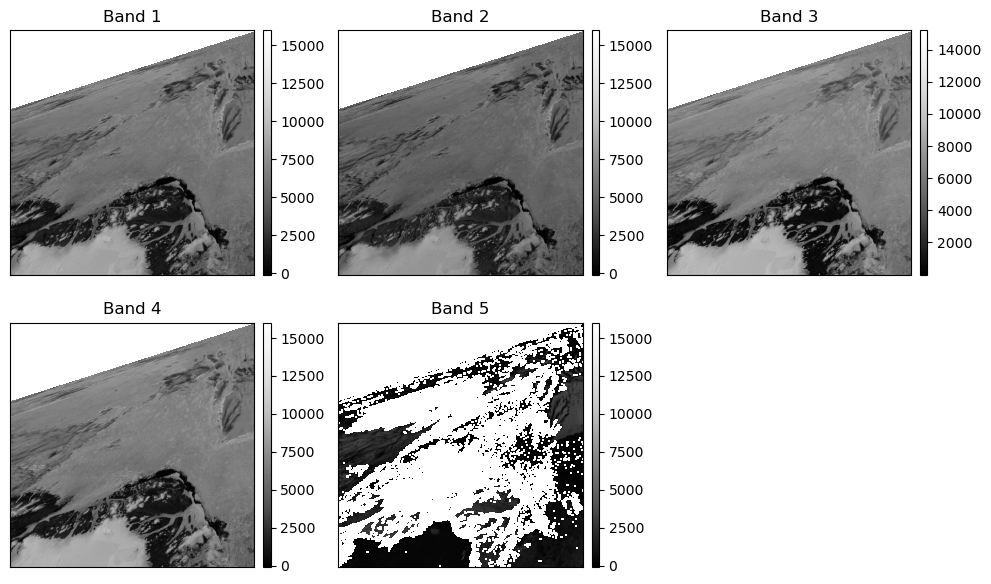

In [39]:
# You can plot each band easily using a data array object
img_data.to_array()

# Plot the data as a DataArray
# This is only a data exploration step
ep.plot_bands(img_data.to_array().values,
              figsize=(10, 6))
plt.show()

In [40]:
# Select the rgb bands only
rgb_bands = ['sur_refl_b01_1',
             'sur_refl_b03_1',
             'sur_refl_b04_1']
# Turn the data into a DataArray
modis_rgb_xr = img_data[rgb_bands].to_array()
modis_rgb_xr

<xarray.DataArray (variable: 3, y: 2400, x: 2400)>
array([[[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ..., 6656., 6627., 5295.],
        ...,
        [7274., 7340., 7220., ..., 2992., 2977., 3207.],
        [7083., 7363., 7448., ..., 3084., 3084., 2955.],
        [7245., 7416., 7556., ..., 2994., 2994., 2847.]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ..., 6754., 6640., 5774.],
        ...,
        [8391., 8258., 8338., ..., 3843., 3823., 4045.],
        [8249., 8039., 8095., ..., 3905., 3905., 3874.],
        [8303., 8149., 8237., ..., 3874., 3874., 3722.]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ..., 6887., 6728., 5636.],
        ...,
        [8153., 8041., 7962., ..., 3430., 3430., 3654.],
        [7955., 7949., 8071., ..., 3479., 3479., 3400.],
        [8025., 8048., 8132., ..., 3412., 3412., 3266.]]], dtype=float32)
Coordinates:
    band         int64 1
  * x            (x) float64 -1.112e+06 -1.111e+06 -1.111e+06 ... -695.0 -231.7
  * y            (y) float64 1.001e+07 1.001e+07 ... 8.896e+06 8.896e+06
    spatial_ref  int64 0
  * variable     (variable) object 'sur_refl_b01_1' ... 'sur_refl_b04_1'
Attributes: (12/184)
    ADDITIONALLAYERS1KM:                 61
    ADDITIONALLAYERS500M:                13
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ASSOCIATEDSENSORSHORTNAME.1:         MODIS
    AUTOMATICQUALITYFLAG.1:              Passed
    ...                                  ...
    total_additional_observations_1km:   30407383
    total_additional_observations_500m:  42085612
    VERSIONID:                           61
    VERTICALTILENUMBER:                  0
    WESTBOUNDINGCOORDINATE:              -179.999999543434
    ZONEIDENTIFIER:                      Universal Transverse Mercator UTM

/local/jbj13rpu/anaconda3/envs/sat_env/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


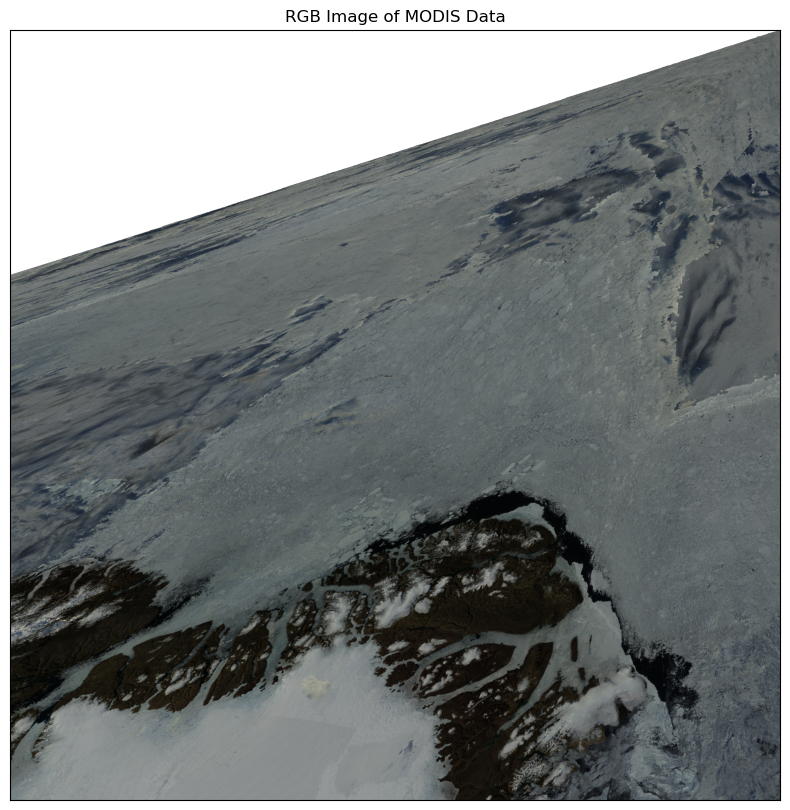

<Axes: title={'center': 'RGB Image of MODIS Data'}>

In [41]:
# Plot MODIS RGB numpy image array
ep.plot_rgb(modis_rgb_xr.values,
            rgb=[0, 2, 1],
            title='RGB Image of MODIS Data')

/local/jbj13rpu/anaconda3/envs/sat_env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


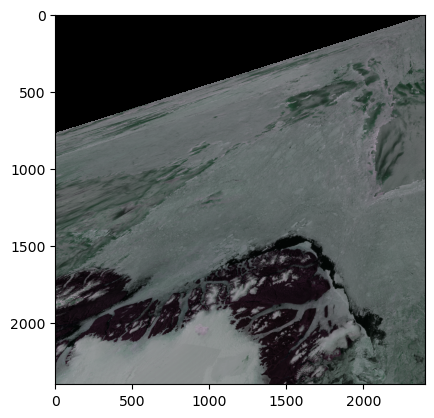

In [42]:
# normalised image example using matplotlib imshow
img = np.dstack(modis_rgb_xr)

norm_img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))
plt.imshow(norm_img)

### Make georeferenced tiff and plot

In [88]:
# create georeferenced tiff
tiff_dir = './MODIS_tiffs/'
os.makedirs(tiff_dir,exist_ok=True)
f_out = f[0:-4] + '.tiff'

red = modis_rgb_xr.values[0]
blue = modis_rgb_xr.values[2]
green = modis_rgb_xr.values[1]

with rio.open(out_dir+f_out,'w',driver='Gtiff',
              width=modis_rgb_xr.rio.width,height=modis_rgb_xr.rio.height,
              count=3,crs=modis_rgb_xr.rio.crs,
              transform=modis_rgb_xr.rio.transform(),
              dtype=blue.dtype) as rgb:
    rgb.write(blue,3)
    rgb.write(green,2)
    rgb.write(red,1)
    rgb.close()

In [44]:
# open tiff for plotting
src = rio.open(out_dir+f_out)

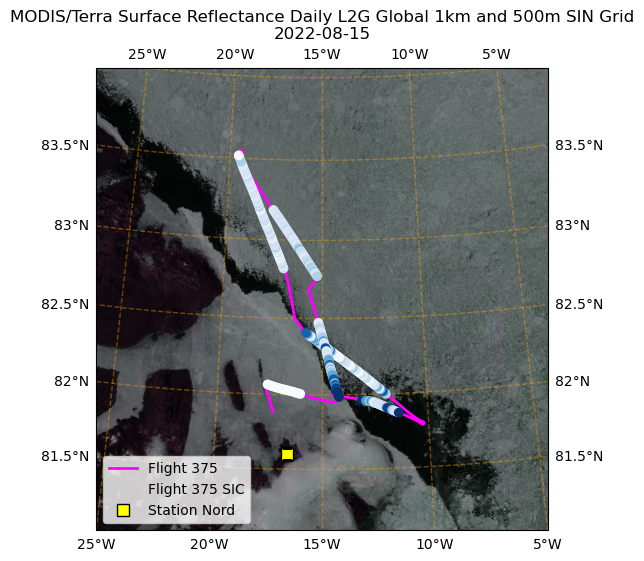

In [79]:
### plot in lat lon coordinates
# image data
left, bottom, right, top = src.bounds
width, height = src.width, src.height
extent = [-25,-5,81,84]

# plot sat image using matplotlib geoaxes
fig = plt.figure(figsize=(6,6))
proj = ccrs.LambertConformal(central_longitude=-15,
                            central_latitude=82)
ax = plt.subplot(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())

# normalise
img = np.dstack(src.read())
norm_img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))

# plot
ax.imshow(norm_img,extent=(left,right,bottom,top),
          transform=ccrs.Sinusoidal())

ax.set_title(img_data.LONGNAME+'\n'+img_data.RANGEBEGINNINGDATE)

# gridlines
g_lons = np.arange(extent[0],extent[1]+5,5)
g_lats = np.arange(extent[2]-1,extent[3]+1,0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                  draw_labels=["x", "y", "top", "bottom", "left", "right"],
                  xlocs=g_lons,
                  ylocs=g_lats,
                  x_inline=False,
                  rotate_labels=False,
                  linewidth=1, color='orange', 
                  alpha=0.4, linestyle='--')

# flight data
# plot some flight data
ds = fetch_flight(ds_list_sr,375)
fli_no = int(ds.flightno.data[0])
flight_track = ax.plot(ds.lon,ds.lat,
                      transform=ccrs.PlateCarree(),
                      color='magenta',
                      linewidth=2,zorder=5,
                      label='Flight '+str(fli_no))
sic = ax.scatter(ds.lon,ds.lat,
                transform=ccrs.PlateCarree(),
                c=ds.icefractionalb.where(ds.altradgps<100),
                zorder=10,
                 cmap='Blues_r',
                label='Flight '+str(fli_no)+' SIC')

# station nord
rothera = ax.plot(-16.636667,81.599167,marker='s',markersize=8,
                  markerfacecolor='yellow',markeredgecolor='k',
                  linestyle='None',
                  transform=ccrs.PlateCarree(), label='Station Nord',
                  zorder=30)

ax.legend(loc='lower left')